In [48]:
import pandas as pd
import spacy
import re

url_real = 'https://drive.google.com/uc?id={}'.format('17JT9YWj_xEIvbacmDcGBlNEUHmwWViAF')
url_fake = 'https://drive.google.com/uc?id={}'.format('18QhQwdVbmXPCsuUx7AF6KyNnitsZdVvM')

# Load data
real_news = pd.read_csv(url_real).head(100)
fake_news = pd.read_csv(url_fake).head(100)

# Combine datasets
real_news['label'] = 1
fake_news['label'] = 0
news_data = pd.concat([real_news, fake_news], ignore_index=True)

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Text cleaning function
def clean_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    return " ".join(tokens)

# Apply text cleaning
news_data['cleaned_text'] = news_data['text'].apply(clean_text)


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [49]:
!pip3 install --quiet "tensorflow-text==2.8.*"

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text


# Load BERT tokenizer from TensorFlow Hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

def preprocess_texts(texts):
    return bert_preprocess(texts)

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense

# Input layer
input_text = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocess_texts(input_text)
bert_outputs = bert_encoder(preprocessed_text)

# Classification head
dropout = Dropout(0.25)(bert_outputs['pooled_output'])
output = Dense(1, activation='sigmoid')(dropout)

# Model definition
model = Model(inputs=[input_text], outputs=[output])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [51]:
# Split data
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(news_data, test_size=0.2, stratify=news_data['label'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'])

# Training
history = model.fit(train_data['cleaned_text'], train_data['label'],
                    validation_data=(val_data['cleaned_text'], val_data['label']),
                    epochs=5, batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


Epoch 1/5
5/5 [==============================] - 93s 14s/step - loss: 1.0146 - accuracy: 0.5312 - val_loss: 1.1355 - val_accuracy: 0.6500
Epoch 2/5
5/5 [==============================] - 58s 12s/step - loss: 0.7522 - accuracy: 0.6125 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 3/5
5/5 [==============================] - 58s 12s/step - loss: 0.6215 - accuracy: 0.6687 - val_loss: 0.7331 - val_accuracy: 0.6500
Epoch 4/5
5/5 [==============================] - 59s 12s/step - loss: 0.6237 - accuracy: 0.6812 - val_loss: 0.5794 - val_accuracy: 0.6500
Epoch 5/5
5/5 [==============================] - 59s 12s/step - loss: 0.5592 - accuracy: 0.6875 - val_loss: 0.5539 - val_accuracy: 0.7000


              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.57      0.80      0.67        10

    accuracy                           0.60        20
   macro avg       0.62      0.60      0.58        20
weighted avg       0.62      0.60      0.58        20

[[4 6]
 [2 8]]
ROC-AUC: 0.76


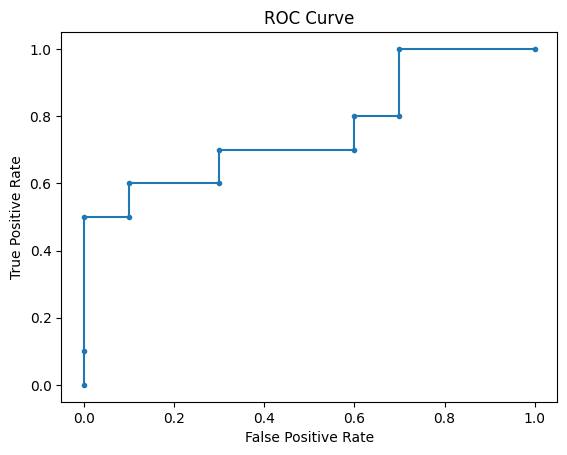

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predictions
test_predictions = model.predict(test_data['cleaned_text'])
test_predictions_bin = (test_predictions > 0.5).astype(int)

# Evaluation
print(classification_report(test_data['label'], test_predictions_bin))
print(confusion_matrix(test_data['label'], test_predictions_bin))

# ROC-AUC
roc_auc = roc_auc_score(test_data['label'], test_predictions)
print(f'ROC-AUC: {roc_auc}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_data['label'], test_predictions)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
